# ML in Cybersecurity: Project II

## Team
  * **Team name**:  *Noobies*
  * **Members**:  *Mejbah Uddin Shameem (s8mesham@stud.uni-saarland.de), Norman Becker (nobe00001@stud.uni-saarland.de), Philipp Baus (s8phbaus@stud.uni-saarland.de)*


## Logistics
  * **Due date**: 14th December 2020, 13:59:59 
  * Email the completed notebook to mlcysec_ws2021_staff@lists.cispa.saarland 
  * Complete this in the previously established **teams of 3**
  * Feel free to use the course [mailing list](https://lists.cispa.saarland/listinfo/mlcysec_ws2021_stud) to discuss.
  
## Timeline
  * 30-Nov-2020: Project 2 hand-out
  * **14-Dec-2020** (13:59:59): Email completed notebook to mlcysec_ws2021_staff@lists.cispa.saarland

  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending against them. To this end, we require you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results, though.


 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all!) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.0: Initial notebook
  * v1.1: Clarifications at 1.1.2, 1.2.2, 2.1
 
  ---

In [ ]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [ ]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [ ]:
compute_mode = 'cpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [ ]:
def identity_func(foo):
    return foo

# ------ Start Your Code ------

# modify image with fgsm, formular to attack the image
def fgsm(img, epsilon, gradient):
    signed_gradient = gradient.sign()
    modified_img = img + epsilon * signed_gradient
    modified_img = torch.clamp(modified_img, 0, 1)
    return modified_img

# creates the fgsm image,from a given image and epsilion.
def create_fgsm_image(img, epsilon):
    img.requires_grad = True
    predicted = net(img)
    loss = criterion(predicted, label)   # calculate loss
    net.zero_grad()
    loss.backward()
    gradient = img.grad.data #Calculate the gradient.
    modified_img = fgsm(img, epsilon, gradient)
    return modified_img

# Data preparation used in 1.1.3
class FGSM_Dataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__ (self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (self.images[idx], self.labels[idx])

# ------ END Your Code --------

# 1. Attacking an ML-model

In this section, we implement an attack ourselves. We then leverage the Foolbox library to craft adversarial examples. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from project 1.

Hint: you might want to save the trained model to save time later.

### 1.1.1: Setting up the model (5 Points)

Re-use the model from project 1 here and train it until it achieves reasonable accuracy (>92%).

In [ ]:
# ------ Start Your Code ------

# (1)load data 
data_trainval = datasets.MNIST(root="./dataset", train=True, download=True, transform=None, 
                                      target_transform=None)
data_test = datasets.MNIST("./dataset", train=False, download=True, transform=None, 
                                     target_transform=None)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

data_trainval.transform = transform
data_test.transform = transform

trainloader = torch.utils.data.DataLoader(data_trainval, 32,
                                              shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(data_test, 1,
                                              shuffle=True, num_workers=0)
# (2)define model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16,5)
        self.fc1   = nn.Linear(256, 128)
        self.fc2   = nn.Linear(128, 10)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x  

net = Net()
net = net.to(device)
net.load_state_dict(torch.load('./cnn_mnist.pth'))
net.eval()

# (3)define loss, optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), 0.01, 0.9)

# (4)train (You can re-use the trained model from project1)

# (5)evaluate
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            #get the smaples from the test data
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # get the prediction in outputs
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            # measure of correct predictions
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total 
    return accuracy
  
print('Accuracy on test data : %d %%' % (test(net)))

# print('Epoch %d, Train acc: %f, Test acc: %f' % (epoch, train_acc, test_acc))

# ------ END Your Code --------

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw




Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Accuracy on test data : 98 %


### 1.1.2: Implementing an attack (15 Points)

We now want you to attack the model trained in the previous step. Please implement the FGSM attack mentioned in the lecture. 

In [ ]:
# ------ Start Your Code ------

accuracies = []
epsilon = [0.1, 0.4, 0.6, 0.8, 1, 1.2]
start = time.time()

for e in epsilon:      # use multiple epsilon to attack the model
    correct = 0
    total = 0
    for image, label in testloader:
        image, label = image.to(device), label.to(device)
        image.requires_grad = True  # is needed for gradient calculation

        # predict the label of the image with the original image
        predicted = net(image)
        _, prediction = torch.max(predicted.data, 1)

        # if prediction was incorrect then we don't have to do anything further
        if ((prediction == label).sum().item() == 1):
            loss = criterion(predicted, label)   # calculate loss
            net.zero_grad()
            loss.backward()
            gradient = image.grad.data

            # modify image with fgsm
            modified_img = fgsm(image, e, gradient)

            # predict modified image and check if prediction is correct or not
            predicted = net(modified_img)
            _, prediction = torch.max(predicted.data, 1)
            total += label.size(0)
            correct += (prediction == label).sum().item()

    # calculate accuracy for the current epsilon  
    accuracy = (correct / total) * 100
    accuracies.append(accuracy)
    print("Accuracy for Epsilon = {}: {}%".format(e, accuracy))

end = time.time()
print("Elapsed time to attack all Test Data of MNIST using FGSM:", end-start)
# ------ END Your Code --------


Accuracy for Epsilon = 0.1: 99.24188820378045%
Accuracy for Epsilon = 0.4: 96.65419993935106%
Accuracy for Epsilon = 0.6: 72.1419185282523%
Accuracy for Epsilon = 0.8: 31.011826544021027%
Accuracy for Epsilon = 1: 10.744971191751745%
Accuracy for Epsilon = 1.2: 5.033862326897807%


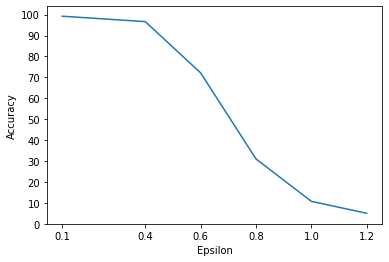

Best Epsilon = 1.2


In [ ]:
# ------ Start Your Code ------
plt.plot(epsilon, accuracies)
plt.xticks(epsilon)
plt.yticks(np.arange(0, 101, step=10))
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()
best_epsilon = epsilon[accuracies.index(min(accuracies))]
print("Best Epsilon = {}".format(best_epsilon))
 # ------ END Your Code --------

### 1.1.3: adversarial sample set (5 Points)

Please additionally generate a dataset containing at least 1,000 adversarial examples using FGSM.

In [ ]:
# ------ Start Your Code ------

modified_images = []
labels = []
for image, label in trainloader:  # create 2000 examples  
    if (len(labels)) == 2000:
        break
    image, label = image.to(device), label.to(device)
    modified_images.append(create_fgsm_image(image, best_epsilon))
    labels.append(prediction[0])

dataset = FGSM_Dataset(modified_images, labels) #save examples in dataset 

# ------ END Your Code --------

### 1.1.3: Visualizing the results (5 Points)

Please chose one sample for each class (for example the first when iterating the test data) and plot the (ten) adversarial examples as well as the predicted label (before and after the attack)

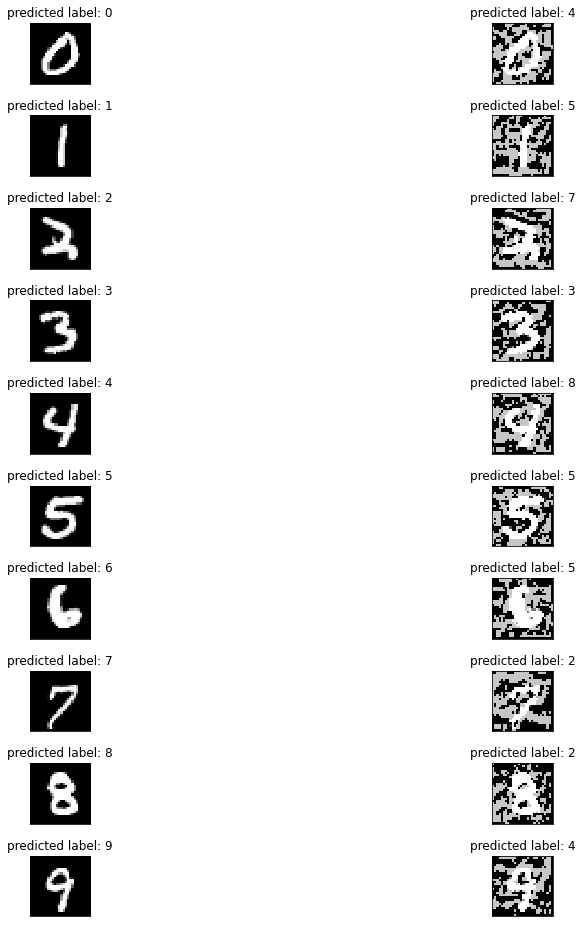

In [ ]:
# ------ Start Your Code ------
rows, cols = 10, 2
fig,ax = plt.subplots(nrows = rows, ncols = cols, figsize=(13, 13))
fig.tight_layout()

for i in range(0, 10):
    for image, label in testloader:
        image, label = image.to(device), label.to(device)
        if label[0] == i:
            # plot image before the attack and its prediction
            predicted = net(image)
            _, prediction = torch.max(predicted.data, 1)
            ax[i][0].set_title("predicted label: {}".format(prediction.item()))
            ax[i][0].imshow(torch.reshape(image, (28, 28)))
            ax[i][0].get_xaxis().set_visible(False)
            ax[i][0].get_yaxis().set_visible(False)

            # plot image after the attack and its prediction
            modified_img = create_fgsm_image(image, best_epsilon)
            predicted = net(modified_img)
            _, prediction = torch.max(predicted.data, 1)
            ax[i][1].set_title("predicted label: {}".format(prediction.item()))
            ax[i][1].imshow(modified_img.detach().numpy().reshape((28, 28)), cmap="gray")
            ax[i][1].get_xaxis().set_visible(False)
            ax[i][1].get_yaxis().set_visible(False)
            break

plt.show()
# ------ END Your Code --------

### 1.2.1: Using libraries for attacks (10 Points)
As the field of evasion attacks (in particular for DNN) is very active research field, several libraries have been published that contain attacks. We will work here with the Foolbox (https://github.com/bethgelab/foolbox) library. Please implement two other (recent, advanced) attacks of your choice using this library. 

In [ ]:
# ------ Start Your Code ------
import foolbox as fb

testloader = torch.utils.data.DataLoader(data_test, 16,
                                              shuffle=True, num_workers=0)
fmodel = fb.PyTorchModel(net, bounds=(0, 1))
attack = fb.attacks.LinfPGD()

# (a) attack 1

accuracies = []
epsilons = [0.1, 0.4, 0.6, 0.8, 1.0, 1.2]
start = time.time()

for e in epsilons:      # use multiple epsilon to attack the model
    correct = 0
    total = 0
    for image, label in testloader:
        image, label = image.to(device), label.to(device)
        raw, advs, success = attack(fmodel, image, label, epsilons=e)
      # predict modified image and check if prediction is correct or not
        predicted = net(advs)
        _, prediction = torch.max(predicted.data, 1)
        total += label.size(0)
        correct += (prediction == label).sum().item()

# calculate accuracy for the current epsilon  
    accuracy = (correct / total) * 100
    accuracies.append(accuracy)
    print("Accuracy for Epsilon = {}: {}%".format(e, accuracy))


end = time.time()
print("Elapsed time to attack all Test Data of MNIST using LinfPGD:", end-start)

     |████████████████████████████████| 1.7MB 8.8MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 163kB 30.1MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Accuracy for Epsilon = 0.1: 98.81%
Accuracy for Epsilon = 0.4: 97.95%
Accuracy for Epsilon = 0.6: 90.5%
Accuracy for Epsilon = 0.8: 59.12%
Accuracy for Epsilon = 1.0: 15.39%
Accuracy for Epsilon = 1.2: 1.21%


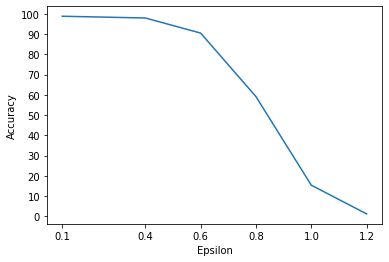

Best Epsilon = 1.2


In [ ]:
# Plot Accuracies for different Epsilons
plt.plot(epsilons, accuracies)
plt.xticks(epsilons)
plt.yticks(np.arange(0, 101, step=10))
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()
best_epsilon1 = epsilons[accuracies.index(min(accuracies))]
print("Best Epsilon = {}".format(best_epsilon1))

In [ ]:
# (b) attack 2
import foolbox as fb
fmodel2 = fb.PyTorchModel(net, bounds=(0, 1))
attack2 = fb.attacks.L2ContrastReductionAttack()

accuracies = []
epsilons = [26, 28, 30, 32, 34, 36, 38, 40]
start = time.time()

for e in epsilons:      # use multiple epsilon to attack the model
    correct = 0
    total = 0
    for image, label in testloader:
        image, label = image.to(device), label.to(device)
        raw, advs, success = attack2(fmodel2, image, label, epsilons=e)
      # predict modified image and check if prediction is correct or not
        predicted = net(advs)
        _, prediction = torch.max(predicted.data, 1)
        total += label.size(0)
        correct += (prediction == label).sum().item()

# calculate accuracy for the current epsilon  
    accuracy = (correct / total) * 100
    accuracies.append(accuracy)
    print("Accuracy for Epsilon = {}: {}%".format(e, accuracy))

end = time.time()
print("Elapsed time to attack all Test Data of MNIST using L2 Contrast Reduction:", end-start)    

Accuracy for Epsilon = 26: 96.69%
Accuracy for Epsilon = 28: 85.61999999999999%
Accuracy for Epsilon = 30: 54.98%
Accuracy for Epsilon = 32: 26.740000000000002%
Accuracy for Epsilon = 34: 13.79%
Accuracy for Epsilon = 36: 10.2%
Accuracy for Epsilon = 38: 9.11%
Accuracy for Epsilon = 40: 8.92%


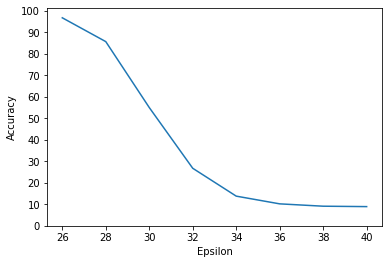

Best Epsilon = 40


In [ ]:
# Plot Accuracies for different Epsilons
plt.plot(epsilons, accuracies)
plt.xticks(epsilons)
plt.yticks(np.arange(0, 101, step=10))
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()
best_epsilon2 = epsilons[accuracies.index(min(accuracies))]
print("Best Epsilon = {}".format(best_epsilon2))
# ------ END Your Code --------

### 1.2.2: Visualizing the results (20 Points)
As before, please plot the new adversarial examples. Compare all crafting techniques (FGSM, 2 methods from Foolbox).


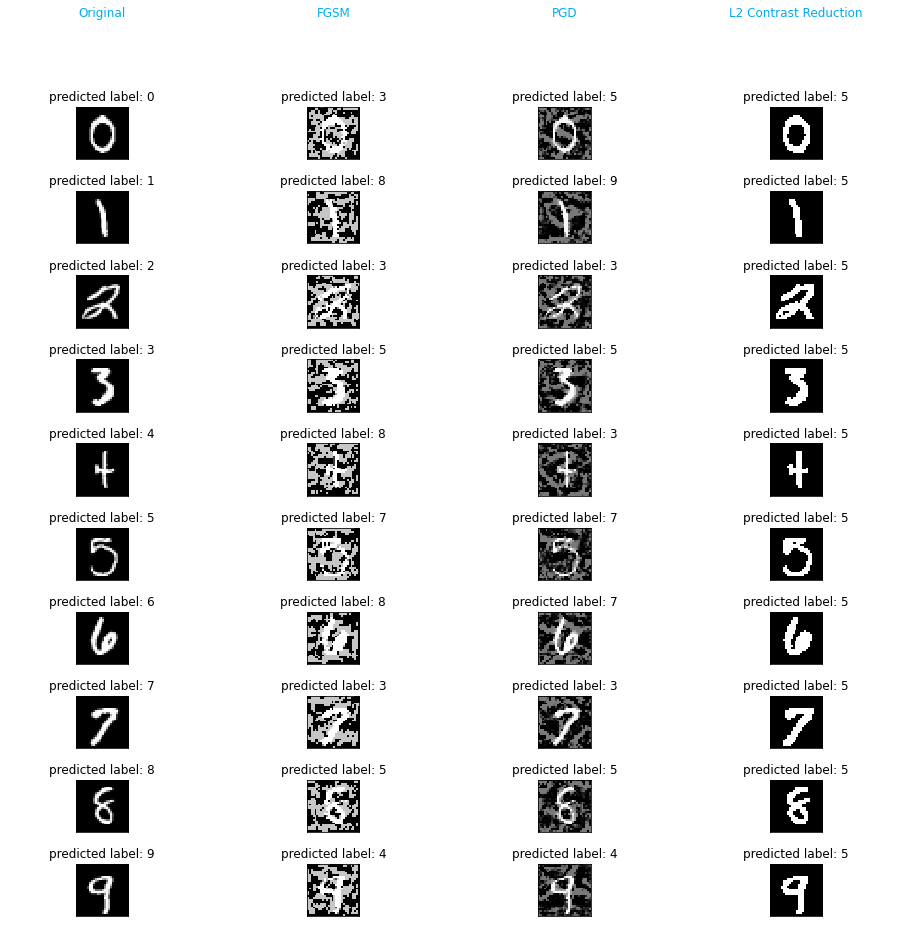

In [ ]:
# template code (Please feel free to change this)
# (each column corresponds to one attack method)

# ------ Start Your Code ------
testloader = torch.utils.data.DataLoader(data_test, 1,
                                              shuffle=True, num_workers=0) #Making batch size 1 for easy parsing

rows, cols = 11, 4
fig,ax = plt.subplots(nrows = rows, ncols = cols, figsize=(13, 13))
fig.tight_layout()

for i in range(0, 10):
    if i == 0:
        ax[i][0].set_title('Original', color='#06ABEE')
        ax[i][1].set_title('FGSM', color='#06ABEE')
        ax[i][2].set_title('PGD', color='#06ABEE')
        ax[i][3].set_title('L2 Contrast Reduction', color='#06ABEE')
        ax[i][0].axis('off')
        ax[i][1].axis('off')
        ax[i][2].axis('off')
        ax[i][3].axis('off')
        
    for image, label in testloader:
        image, label = image.to(device), label.to(device)
            
        if label[0] == i:

            # LINFPGD
            raw, advs, success = attack(fmodel, image, label, epsilons=best_epsilon1)
            # predict modified image and check if prediction is correct or not for Projected Gradient Descent Attack
            predicted = net(advs)
            _, prediction = torch.max(predicted.data, 1)
            ax[i+1][2].set_title("predicted label: {}".format(prediction.item()))
            ax[i+1][2].imshow(advs.cpu().detach().numpy().reshape((28, 28)), cmap="gray")
            ax[i+1][2].get_xaxis().set_visible(False)
            ax[i+1][2].get_yaxis().set_visible(False)

             # L2 CONTRAST REDUCTION
            raw, advs, success = attack2(fmodel2, image, label, epsilons=best_epsilon2)
            # predict modified image and check if prediction is correct or not for Deep Fool Attack
            predicted = net(advs)
            _, prediction = torch.max(predicted.data, 1)
            ax[i+1][3].set_title("predicted label: {}".format(prediction.item()))
            ax[i+1][3].imshow(advs.cpu().detach().numpy().reshape((28, 28)), cmap="gray")
            ax[i+1][3].get_xaxis().set_visible(False)
            ax[i+1][3].get_yaxis().set_visible(False)

            # ORI
            # Original Test Image 
            predicted = net(image)
            _, prediction = torch.max(predicted.data, 1)
            ax[i+1][0].set_title("predicted label: {}".format(prediction.item()))
            ax[i+1][0].imshow(torch.reshape(image.cpu(), (28, 28)))
            ax[i+1][0].get_xaxis().set_visible(False)
            ax[i+1][0].get_yaxis().set_visible(False)

            # FGSM
            # predict modified image and check if prediction is correct or not for FGSM Attack
            modified_img = create_fgsm_image(image, best_epsilon)
            predicted = net(modified_img)
            _, prediction = torch.max(predicted.data, 1)
            ax[i+1][1].set_title("predicted label: {}".format(prediction.item()))
            ax[i+1][1].imshow(modified_img.cpu().detach().numpy().reshape((28, 28)), cmap="gray")
            ax[i+1][1].get_xaxis().set_visible(False)
            ax[i+1][1].get_yaxis().set_visible(False)
            break

plt.show()
 # ------ END Your Code --------      

In [ ]:
# ------ Start Your Code ------
# Calculating L0,L2,Linf Norm for a sample image for different attacks for the summary section
def calc_norm(image,p):
    return torch.norm(image, p=p)

image, label = next(iter(testloader))  
image, label = image.to(device), label.to(device)

# Original image norms
L0_ori, L2_ori, Linf_ori = calc_norm(image, 0), calc_norm(image, 2), calc_norm(image, float("inf"))
print("Original image: LO = {}, L2 = {}, Linf = {}".format(L0_ori, L2_ori, Linf_ori))

# LinfPGD attack image norms
_, advs, _ = attack(fmodel, image, label, epsilons=best_epsilon1)
L0_PGD, L2_PGD, Linf_PGD = calc_norm(advs, 0), calc_norm(advs, 2), calc_norm(advs, float("inf"))
print("LinfPGD attack image: LO = {}, L2 = {}, Linf = {}".format(L0_PGD, L2_PGD, Linf_PGD))

# L2 Contrast Reduction attack image norms
_, advs, _ = attack2(fmodel2, image, label, epsilons=best_epsilon2)
L0_L2CTRD, L2_L2CTRD, Linf_L2CTRD = calc_norm(advs, 0), calc_norm(advs, 2), calc_norm(advs, float("inf"))
print("L2 contrast reduction attack image: LO = {}, L2 = {}, Linf = {}".format(L0_L2CTRD, L2_L2CTRD, Linf_L2CTRD))

# FGSM attack image norms
modified_img = create_fgsm_image(image, best_epsilon)
L0_FGSM, L2_FGSM, Linf_FGSM = calc_norm(modified_img, 0).data.numpy(), calc_norm(modified_img, 2).data.numpy(), calc_norm(modified_img, float("inf")).data.numpy()
print("FGSM attack image: LO = {}, L2 = {}, Linf = {}".format(L0_FGSM, L2_FGSM, Linf_FGSM))
# ------ END Your Code --------

**Which differences do you observe when comparing different attack methods? Why?**

We see that Fast Grdient Sign Method (FGSM) calculates the gradient of the cost with respect to the input pixels and then optimizes the image to increase loss, holding the parameters constant. We finish with values that indicate how much the loss would change if that pixel value were updated by a single unit. FGSM takes the gradient and the sign of it and the method chooses some epsilons, and multiples the two together. Finally, this is added to the input image to get the modified perturbed image. 

Projected Gradient Descent(PGD) tries to find the distortion that maximises the loss of a model on a particular input while keeping the size of the perturbation smaller than epsilon. The constraint is referred as the L² or L∞ norm of the perturbation and in our adversary L∞ norm is used. 

In the constraint reduction attack, in gerneral the gradual distortion occurs for the pixels as follows:

$$target = \frac{max + min}2$$
$$perturbed = (1 - \epsilon) * image + \epsilon * target$$

where min and max values are computed across all pixels of images.

[source: *Adam Dziedzic, Sanjay Krishnan. Analysis of Random Perturbations for Robust
Convolutional Neural Networks.*]

From the visualization, it seems that FGSM and PGD distorts the image quite similary as expected and causes the misclassification whereas contrast reduction attack clearly affects the contrast of the image while misclassifying evrything to class 5 here interestingly. 


**Does the attack always succeed (the model make wrong prediction on the adversarial sample)?**

We would say in the given particular scenerio, the CNN model we trained for MNIST can be the victim almost ALWAYS. We observed that we just need to fine tune the epsilon according to different adversaries to make the model predicting wrong ALWAYS(~90%).

**How different is the adversarial sample from the original image?
(L0,L2,Linf norm)**  

It seems like for L2 contrast reduction the L0 norm is quite similar to with the LO norm of the original image while for the remaining attacks the image's L0 norms are much smaller. Linf norm is smallest for L2 contrast reduction compared to other two. More details of the norms for different attacks for a sample image is already available in the above code section. 

**How about the computation cost of each attack method?**

The gradient based methods should be computationally slower/costlier than that of contrast based method where something like sophisticated loss and gradient calculation are not invloved. This statement is validated while analyzing the time required for each attack. The LinfPGD attack takes more than 13 minutes to complete, FGSM requires about 3 minutes to run whereas, L2 Contrast Reduction only requires 35 seconds to finish the attack on MNIST test images which is minimum among all as expected.

**Does the attack require white-box access to the model?**

The LinfPGD and FGSM attacks are gradient based attacks and they require white-box access to the victim model. However, the L2 Contrast Reduction attack is a black-box attack as it only gradually distorts all the pixels of the image.

# 2. Defending an ML model

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. As before concerning the attack, you can chose an example from the lecture, or experiment with any idea you have.

We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

### 2.1: Implementing a defense of your choice (25 Points)
As stated before, feel free to implement a defense or mitigation of your choice. Evaluate the defense on adversarial examples. This entails at least the 1,000 examples crafted from FGSM.   
Also, you are encouraged (optional) to defend against the two other attack methods, i.e. you are free to increase this special test set (for example by >30 examples (>10 from your FGSM attack, >10 from both the two other attacks of the library)).

#### Build an autoencoder


In [ ]:
# ------ Start Your Code ------
mode = "already_trained"
testloader = torch.utils.data.DataLoader(data_test, 1,
                                              shuffle=True, num_workers=0)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.ConvTranspose2d(16, 6, 5)
        self.conv4 = nn.ConvTranspose2d(6, 1, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        return x
# ------ END Your Code --------

##### Train the autoencoder

In [ ]:
# ------ Start Your Code ------
epsilon = [0.1, 0.4, 0.6, 0.8, 1.0, 1.2]   # train the autoencoder for multiple epsilon values

def train(autoenc, opt, epochs, criterion_1, criterion_2):
    for epoch in range(epochs):
        losses = []
        for image, label in trainloader:
            for e in epsilon:
                # create the fgsm images
                image = image.to(device)
                image.requires_grad = True
                predicted = net(image)
                loss = criterion_1(predicted, label)
                net.zero_grad()
                loss.backward()
                gradient = image.grad.data
                modified_img = fgsm(image, e, gradient)

                # use them as input for the autoencoder
                output = autoenc(modified_img)

                # calculate the loss between the original image before the fgsm attack
                # and the output and update the weights according to this
                loss = criterion_2(output, image)
                losses.append(loss.item())
                autoenc.zero_grad()
                loss.backward()
                opt.step()
        print("epoch {}: loss={}".format(epoch+1, sum(losses)/len(losses)))
        plt.imshow(output[0].detach().numpy().reshape((28, 28)))
        plt.show()
        plt.imshow(modified_img[0].detach().numpy().reshape((28, 28)))
        plt.show()
# ------ END Your Code --------   

##### Initialization of the autoencoder

In [ ]:
# ------ Start Your Code ------
if mode == "train":
    criterion = nn.CrossEntropyLoss()
    criterion2 = nn.MSELoss()
    epochs = 40
    # lr=0.005
    # momentum=0.9
    autoencoder = Autoencoder()
    autoencoder = autoencoder.to(device)
    # optimizer = optim.SGD(autoencoder.parameters(), lr, momentum)  # lead to many negative trainings
    optimizer = optim.Adam(autoencoder.parameters(), 0.0005)         # better choice
    train(autoencoder, optimizer, epochs, criterion, criterion2)
    torch.save(autoencoder.state_dict(), "./autoencoder.pth")
else:
    autoencoder = Autoencoder()
    autoencoder = autoencoder.to(device)
    autoencoder.load_state_dict(torch.load("./autoencoder.pth"))
    autoencoder.eval()
# ------ END Your Code --------

#### Attacking the original model

In [ ]:
# ------ Start Your Code ------
e = best_epsilon
correct = 0
total = 0
for image, label in testloader:
    image, label = image.to(device), label.to(device)
    image.requires_grad = True  # is needed for gradient calculation

    predicted = net(image)
    loss = criterion(predicted, label)   # calculate loss
    net.zero_grad()
    loss.backward()
    gradient = image.grad.data

    # modify image with fgsm
    modified_img = fgsm(image, e, gradient)

    # predict modified image and check if prediction is correct or not
    predicted = net(modified_img)
    _, prediction = torch.max(predicted.data, 1)
    total += label.size(0)
    correct += (prediction == label).sum().item()

acc_FGSM = (correct / total) * 100
# ------ END Your Code --------

#### Attacking the model defended by the autoencoder

In [ ]:
# ------ Start Your Code ------
correct = 0
total = 0
for image, label in testloader:
    image, label = image.to(device), label.to(device)
    image.requires_grad = True  # is needed for gradient calculation

    predicted = net(image)
    loss = criterion(predicted, label)   # calculate loss
    net.zero_grad()
    loss.backward()
    gradient = image.grad.data

    # modify image with fgsm
    modified_img = fgsm(image, e, gradient)

    # put image into autoencoder
    output = autoencoder(modified_img)

    # predict modified image with output of autoencoder and check if prediction is correct or not
    predicted = net(output)
    _, prediction = torch.max(predicted.data, 1)
    total += label.size(0)
    correct += (prediction == label).sum().item()
  
acc_FGSM_defend = (correct / total) * 100
# ------ END Your Code --------

#### Analyze the results

In [ ]:
print('Accuracy on adversarial samples (FGSM) %.2f'%acc_FGSM + "%")
print('Accuracy on adversarial samples (FGSM) after defense %.2f'%acc_FGSM_defend + "%")

Accuracy on adversarial samples (FGSM) 4.98
Accuracy on adversarial samples (FGSM) after defense 81.76%


#### Plot the results




Epsilon = 0.8:


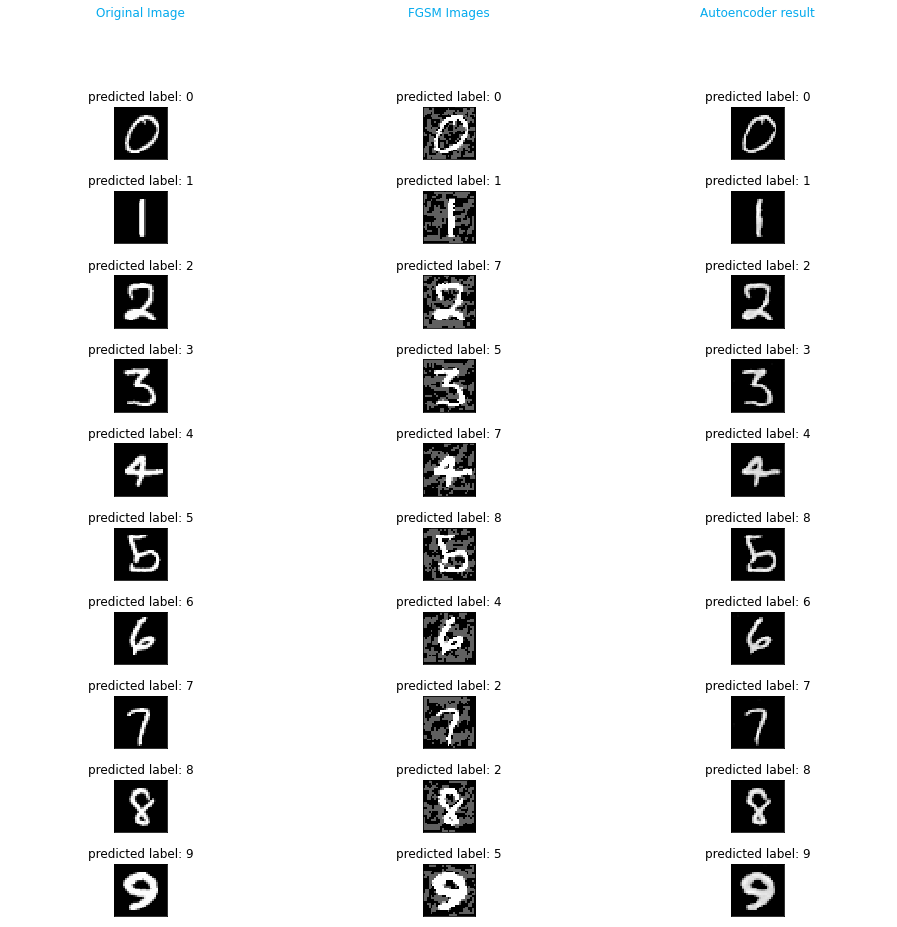




Epsilon = 1.0:


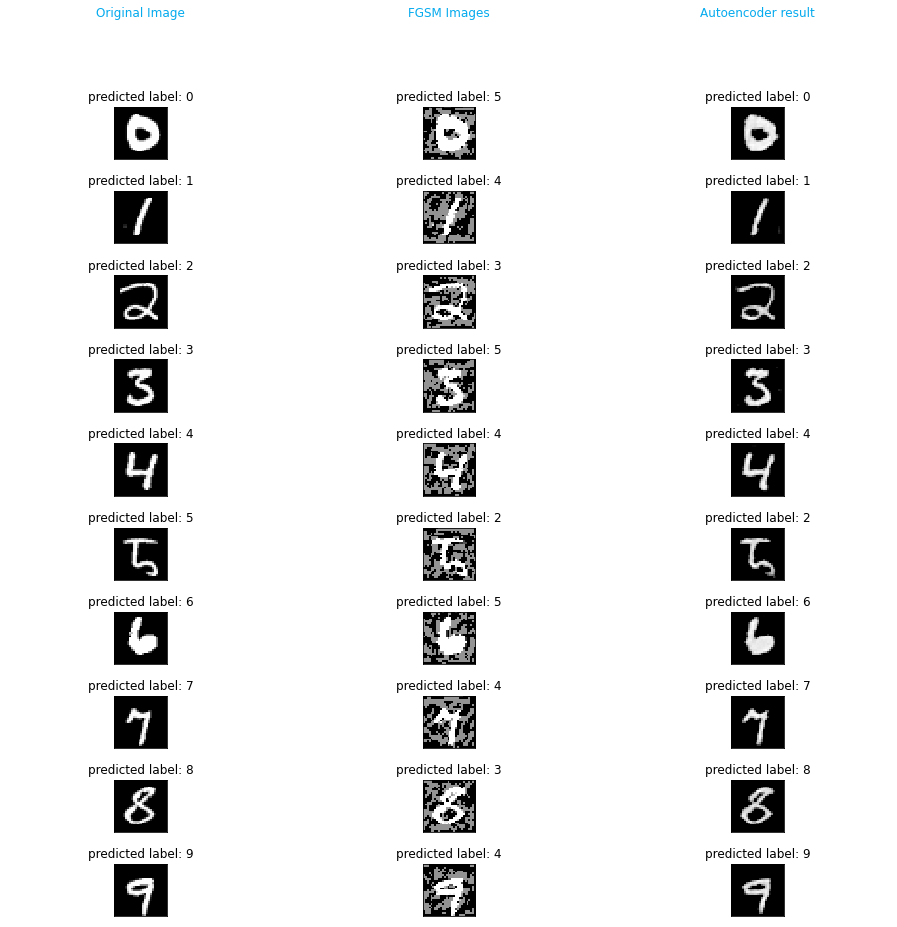




Epsilon = 1.2:


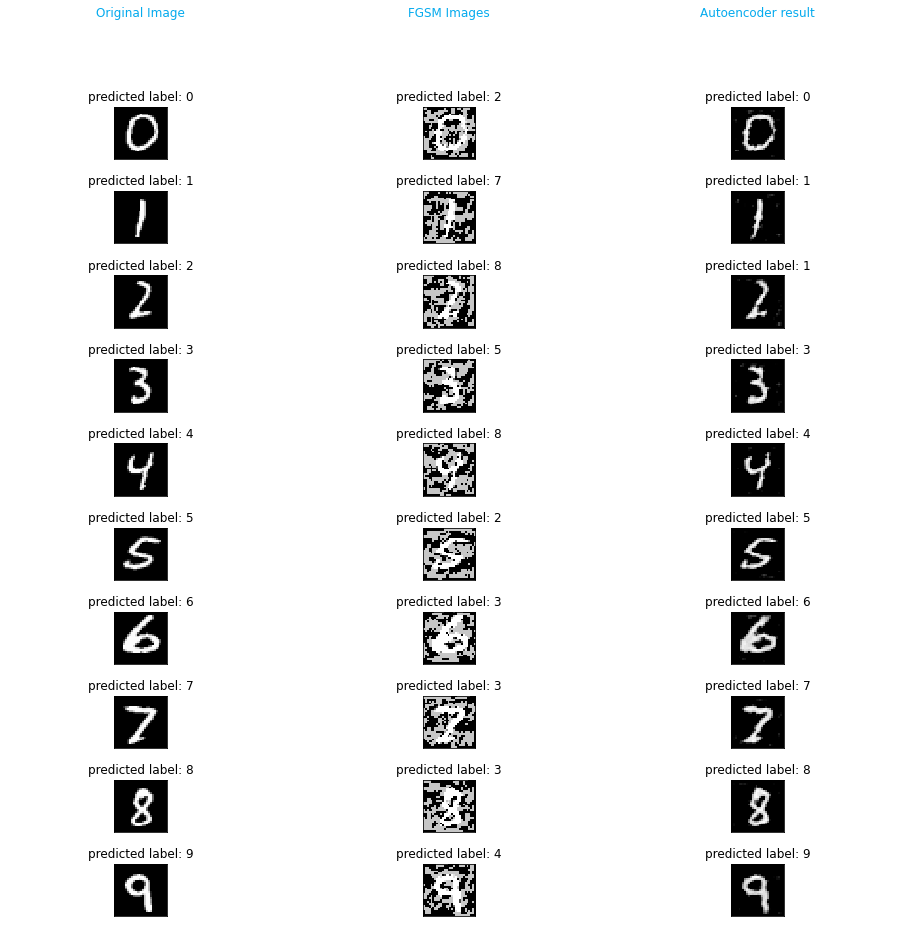

In [ ]:
# ------ Start Your Code ------
for e in [0.8, 1.0, 1.2]:
    rows, cols = 11, 3
    fig,ax = plt.subplots(nrows = rows, ncols = cols, figsize=(13, 13))
    fig.tight_layout()

    print("\n\n\n\033[1mEpsilon =", str(e) + ":")
    ax[0][0].set_title('Original Image', color='#06ABEE')
    ax[0][1].set_title('FGSM Images', color='#06ABEE')
    ax[0][2].set_title('Autoencoder result', color='#06ABEE')
    ax[0][0].axis('off')
    ax[0][1].axis('off')
    ax[0][2].axis('off')


    for i in range(1, 11):
        for image, label in testloader:
            image, label = image.to(device), label.to(device)
            if label[0] == i-1:
                # plot image before the attack and its prediction
                predicted = net(image)
                _, prediction = torch.max(predicted.data, 1)
                if prediction != label:
                    continue
                ax[i][0].set_title("predicted label: {}".format(prediction.item()))
                ax[i][0].imshow(image.detach().numpy().reshape((28, 28)))
                ax[i][0].get_xaxis().set_visible(False)
                ax[i][0].get_yaxis().set_visible(False)

                # plot image after the attack and its prediction
                modified_img = create_fgsm_image(image, e)
                predicted = net(modified_img)
                _, prediction = torch.max(predicted.data, 1)
                ax[i][1].set_title("predicted label: {}".format(prediction.item()))
                ax[i][1].imshow(modified_img.detach().numpy().reshape((28, 28)), cmap="gray")
                ax[i][1].get_xaxis().set_visible(False)
                ax[i][1].get_yaxis().set_visible(False)

                # plot image after usage of the autoencoder and its prediction
                autoencoder_img = autoencoder(modified_img)
                predicted = net(autoencoder_img)
                _, prediction = torch.max(predicted.data, 1)
                ax[i][2].set_title("predicted label: {}".format(prediction.item()))
                ax[i][2].imshow(autoencoder_img.detach().numpy().reshape((28, 28)), cmap="gray")
                ax[i][2].get_xaxis().set_visible(False)
                ax[i][2].get_yaxis().set_visible(False)
                break
    plt.show()
# ------ END Your Code --------

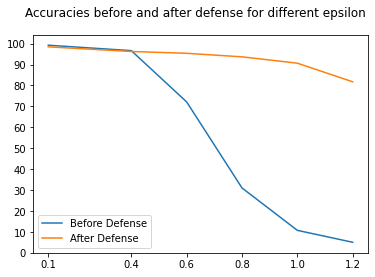

In [ ]:
# ------ Start Your Code ------
precomputed_attack_accuracies = [99.24, 96.65, 72.14, 31.01, 10.74, 5.03]
epsilon = [0.1, 0.4, 0.6, 0.8, 1, 1.2]
accuracies_defended = []
for e in epsilon:
    correct = 0
    total = 0
    for image, label in testloader:
        # image, label = image.to(device), label.to(device)
        # image.requires_grad = True  # is needed for gradient calculation

        # predicted = net(image)
        # loss = criterion(predicted, label)   # calculate loss
        # net.zero_grad()
        # loss.backward()
        # gradient = image.grad.data

        # modify image with fgsm
        modified_img = create_fgsm_image(image, e)

        # put image into autoencoder
        output = autoencoder(modified_img)

        # predict modified image with output of autoencoder and check if prediction is correct or not
        predicted = net(output)
        _, prediction = torch.max(predicted.data, 1)
        total += label.size(0)
        correct += (prediction == label).sum().item()
    accuracies_defended.append((correct / total) * 100)


plt.suptitle("Accuracies before and after defense for different epsilon")
attack = plt.plot(epsilon, precomputed_attack_accuracies, label="Before Defense")
defense = plt.plot(epsilon, accuracies_defended, label ="After Defense")
plt.xticks(epsilon)
plt.yticks(np.arange(0, 101, step=10))
plt.legend()
plt.show()
# ------ END Your Code --------

### 2.2: Conclusions (15 Points)
**<u> What did you try to make the classifier more robust against FGSM? </u>**

To make the classifier more robust against FGSM, we tried to build an autoencoder, that would then be able to get FGSM attack images as input and to reverse the attack on this image, so that our CNN can recognize the pictures again. So to protect our model with our autoencoder, we simply have to put the trained autoencoder in front of our CNN, so that the output of the autoencoder is used as the input of our CNN.

**<u> Why did it work? </u>**

Our defense worked, because our autoencoder is able to reverse the effects of the FGSM attack by reversing the FGSM image. To do this we have to train the model by inputting the FGSM attack image into the autoencoder and then compute the loss with the output and the original image and then update the weights accordingly. We train the autoencoder also for multiple epsilon values, so that it is not only robust against one epsilon but against a wide range of epsilons. When the autoencoder is finally trained, then it will be able to recognize the most important features of such FGSM attack images and reverse the attack by reconstructing the image with its most important features. So as we can reverse the attack on the images before putting the image into our CNN, we can migitate the effects of the attack pretty well. 

**<u> Is the classifier now robust against FGSM? </u>**

The classifier is now pretty robust against FGSM and will achieve an accuracy much higher than without protection. For epsilons to 1, it will have an accuracy higher than 90%. For epsilons over 1, the accuracy will go down a little bit until arround 80% as then the digits get really akward (some are also not recognizable by humans anymore) and so the autoencoder might get some trouble with reversing some images and will output a not quite optimal. 

**<u> Characteristics of the autoencoder </u>**

We first trained the autoencoder only for one specific epsilon, before we decided to train it for multiple epsilons. We found out that if we train the autoencoder for one epsilon that we have an accuracy arround 97% for that epsilon. For other epsilons the encoder has the same accuracies as without protection. But when we trained it for multiple epsilon values it worked pretty good for all epsilons that it was trained for, but with a slightly lower accuray (arround 80%). At the end we decided to choose the second autoencoder as we want to protect our model not only against one epsilon, but against all of them. We also sent you the first autoencoder that worked only for epsilon = 1.2.

We also found out when learning the autoencoder for this dataset, that the learning process failed when we chose a too high learning rate. In this case the autoencoder started to produce only black pictures from the second epoch on in some cases. When we then started to lower the learning rate it started to work and we had a pretty decent autoencoder. Then we started to improve it by adjusting the parameters as the learning rate and the batch size.

**<u> Expectation of the performance </u>**

First we thought that our encoder would work a little bit better than it did because the most important features of the image don't really change this much in a FGSM attack. So we thought that the autoencoder might find these in most of the cases and so would be able to reverse the attack in almost every case. When we trained it for one epsilon this was the case, but as our intention was to train it for all epsilon this wasn't the case anymore then. The reason for that is that the images look different for the different epsilons and so it must learn to reverse different looking images and so the performance doesn't stay that high for every epsilon.

**<u> Final Conclusion </u>**
But at the end we can say that our autoencoder did a pretty decent job and fulfilled its purpose of defending against FGSM attacks although we couldn't quite reach the original accuracy for every epsilon.